In [ ]:
import sys
sys.path.append("../../")
from utils.class_names import class_names, class_to_idx
from utils.cropping import crop_normalized_bbox_square

In [ ]:
import os
import ast

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast, GradScaler
from torchvision import transforms, datasets
from sklearn.utils.class_weight import compute_class_weight

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class_to_idx['badger']

0

## Feature extraction and head creation

#### Load model

In [ ]:
MODEL_PATH = "../../speciesnet/models/speciesnet-pytorch-v4.0.1a-v1/always_crop_99710272_22x8_v12_epoch_00148.pt"
NUM_CLASSES = len(class_names)  # Number of target Polish species

In [5]:
model = torch.load(MODEL_PATH, map_location="cuda", weights_only=False)

for p in model.parameters():
    p.requires_grad = False

model.eval()

GraphModule(
  (initializers): Module()
  (SpeciesNet/efficientnetv2-m/rescaling/mul): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/rescaling/add): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/stem_conv/Conv2D__6): OnnxTranspose()
  (SpeciesNet/efficientnetv2-m/stem_conv/Conv2D): Sequential(
    (0): OnnxPadStatic()
    (1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2))
  )
  (SpeciesNet/efficientnetv2-m/stem_activation/Sigmoid): Sigmoid()
  (SpeciesNet/efficientnetv2-m/stem_activation/mul_1): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/block1a_project_conv/Conv2D): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (SpeciesNet/efficientnetv2-m/block1a_project_activation/Sigmoid): Sigmoid()
  (SpeciesNet/efficientnetv2-m/block1a_project_activation/mul_1): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/block1a_add/add): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/block1b_project_conv/Conv2D): Conv2d(24, 24, 

#### Get number of speciesnet outputs

In [6]:
dummy = torch.randn(1, 480, 480, 3).to('cuda')
out = model(dummy)
n_original_classes = out.shape[1]
print(out.shape)

torch.Size([1, 2498])


In [7]:
scale = model.initializers.onnx_initializer_0.cpu().numpy()
offset = model.initializers.onnx_initializer_1.cpu().numpy()

print("scale:", scale)
print("offset:", offset)

scale: 1.9921875
offset: -1.0


#### Extract features

In [8]:
class SpeciesNetFeatures(nn.Module):
    def __init__(self, graph_module, feature_node_name):
        super().__init__()
        self.graph = graph_module
        self.feature_node_name = feature_node_name
        self._features = None

        # register hook on the ONNX-traced layer
        layer = getattr(self.graph, feature_node_name)
        layer.register_forward_hook(self._hook)

    def _hook(self, module, inp, out):
        self._features = out

    def forward(self, x):
        _ = self.graph(x)              # run through full graph
        return self._features          # return features BEFORE final classifier

In [9]:
FEATURE_NODE = "SpeciesNet/efficientnetv2-m/avg_pool/Mean_Squeeze__3825"
feat_extractor = SpeciesNetFeatures(model, FEATURE_NODE).to("cuda")

#### Check number of features output by model, before classifier

In [10]:
dummy = torch.randn(1, 480, 480, 3).to("cuda")
feat = feat_extractor(dummy)
feature_dim = feat.shape[1]
print("Feature dim:", feature_dim)

Feature dim: 1280


#### Change classifier in new model

In [11]:
class NewClassifier(nn.Module):
    def __init__(self, feature_dim: int, num_classes: int, dropout: float=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

class SpeciesnetPolish(nn.Module):
    def __init__(self, feature_extractor: SpeciesNetFeatures, num_classes: int):
        super().__init__()
        self.feature_extractor = feature_extractor

        # freeze original SpeciesNet
        for p in self.feature_extractor.parameters():
            p.requires_grad = False

        # get feature dim
        dummy = torch.randn(1, 480, 480, 3).to("cuda")
        feat = self.feature_extractor(dummy)
        feature_dim = feat.shape[1]

        self.classifier = NewClassifier(feature_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        f = self.feature_extractor(x)
        out = self.classifier(f)
        return out

## Training

##### Dataloaders

In [12]:
IMG_SIZE = 480
BATCH_SIZE = 100
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

Number of classes:  26
Number of images:  22810


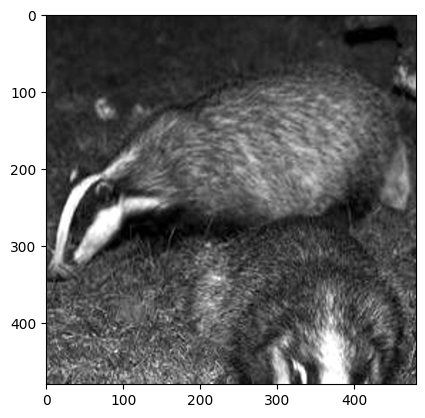

In [13]:
# Filter: accept only files inside pictures_cropped
def is_valid_image(path):
    dirname = os.path.basename(os.path.dirname(path))
    return dirname == "pictures_cropped" and path.lower().endswith(VALID_EXT)

training_data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.05,
        ),
        transforms.ToTensor()
    ])

dataset = datasets.ImageFolder(
    root="../../data",
    transform=training_data_transforms,
    is_valid_file=is_valid_image,
)
print('Number of classes: ', len(dataset.classes))
print('Number of images: ', len(dataset))

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

import matplotlib.pyplot as plt
plt.imshow(dataset[308][0].numpy()[1], cmap='gray')

In [18]:
if dataset.class_to_idx != class_to_idx:
    raise ValueError('Mapping doesn\'t match')

In [24]:
img = dataset[0][0].numpy()
internal = img * scale + offset
print(internal.min(), internal.max())

-0.9140625 0.6484375


Validation/test data:

In [ ]:
def crop_normalized_bbox_square(img: Image.Image, bbox: list[float]):
    """
    img: PIL.Image opened image
    bbox: list [x, y, w, h], normalized 0-1
    returns cropped PIL.Image as square
    """
    W, H = img.size
    x, y, w, h = bbox

    # Convert normalized bbox to pixel coords
    left = int(x * W)
    top = int(y * H)
    right = int((x + w) * W)
    bottom = int((y + h) * H)

    # Original width/height in pixels
    bw = right - left
    bh = bottom - top

    # Determine square side
    side = max(bw, bh)

    # Compute center of bbox
    cx = left + bw // 2
    cy = top + bh // 2

    # Recompute square boundaries
    half = side // 2
    new_left = cx - half
    new_top = cy - half
    new_right = new_left + side
    new_bottom = new_top + side

    # Clamp to image boundaries
    new_left = max(0, new_left)
    new_top = max(0, new_top)
    new_right = min(W, new_right)
    new_bottom = min(H, new_bottom)

    return img.crop((new_left, new_top, new_right, new_bottom))


class CroppedImageDataset(Dataset):
    def __init__(self, df, fraction=0.2):
        # keep only a fraction of rows (randomly)
        self.df = df.sample(frac=fraction, random_state=42).reset_index(drop=True)
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        species = row["species"]
        label = class_to_idx[species]
        bbox = ast.literal_eval(row["bbox"])

        # Load image
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            # choose a random other index and try again
            new_idx = np.random.randint(0, len(self))
            return self.__getitem__(new_idx)
        img = crop_normalized_bbox_square(img, bbox)

        # Transform (resize, ToTensor, etc.)
        if self.transform:
            img = self.transform(img)

        return img, label

In [26]:
df = pd.read_csv('../../y_clean_thin.csv', index_col=0).sample(frac=0.2).reset_index(drop=True)
df_mega = pd.read_csv('../../megadetector_results.csv', index_col=0)
df = df.merge(df_mega, on='image_path')
df.image_path = '../../' + df.image_path
df = df.dropna()
df = df[df["species"].isin(dataset.classes)].reset_index(drop=True)


val_ds = CroppedImageDataset(df)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

##### The loop

imbalanced dataset:

In [28]:
y_train = [label for _, label in dataset.samples]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

In [31]:
number_of_epochs = 20
polish_model = SpeciesnetPolish(feat_extractor, NUM_CLASSES).to("cuda")

optimizer = torch.optim.Adam(polish_model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=weights)
scaler = GradScaler()

best_val = float("inf")
best_state = None

for epoch in range(1, number_of_epochs+1):
    # TRAIN
    train_loss = 0
    polish_model.train()
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        
        with autocast('cuda'):
            logits = polish_model(images)
            loss = criterion(logits, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    # TEST
    polish_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            with autocast('cuda'):
                logits = polish_model(images)
                loss = criterion(logits, labels)
            val_loss += loss.item()

    print(f"epoch {epoch}: train_loss={train_loss:.2f}  val_loss={val_loss:.2f}")

    if val_loss < best_val:
        best_val = val_loss
        best_state = polish_model.state_dict()

checkpoint = {
    'state_dict': best_state,
    'class_names': class_names,
    'feature_node': FEATURE_NODE,
    'num_classes': NUM_CLASSES
}
torch.save(checkpoint, "speciesnet_polish_2_checkpoint.pt")

epoch 1: train_loss=118.56  val_loss=5.10
epoch 2: train_loss=60.88  val_loss=5.32
epoch 3: train_loss=53.10  val_loss=5.31
epoch 4: train_loss=48.26  val_loss=4.82
epoch 5: train_loss=43.82  val_loss=5.28
epoch 6: train_loss=39.74  val_loss=5.18
epoch 7: train_loss=38.29  val_loss=4.87
epoch 8: train_loss=34.67  val_loss=5.79
epoch 9: train_loss=33.07  val_loss=5.29
epoch 10: train_loss=29.21  val_loss=5.74


KeyboardInterrupt: 

In [32]:
checkpoint = {
    'state_dict': best_state,
    'class_names': class_names,
    'feature_node': FEATURE_NODE,
    'num_classes': NUM_CLASSES
}
torch.save(checkpoint, "speciesnet_polish_2_checkpoint.pt")

In [ ]:
labels

tensor([23,  8,  9, 24, 15, 15, 16, 24, 15, 14, 18,  9, 21,  3, 17, 11, 21,  2,
         9, 15,  7,  8, 17, 17, 13,  0, 14, 13,  6, 17,  1,  4,  4,  1,  2, 17,
         9, 23,  7, 19, 15, 17,  2, 11, 13, 22, 19, 15, 11, 14,  0,  8, 11,  1,
         5, 23, 15, 11, 22, 23, 25, 18,  1,  8, 25, 20, 17, 11,  9, 23, 24, 25,
         2, 16,  3, 18, 16, 18, 15,  9, 17, 20, 17, 25,  1, 18, 11,  9, 21,  1,
         1, 16, 20, 12, 25, 14, 22,  6, 19,  7], device='cuda:0')

In [ ]:
torch.argmax(logits, dim=1)

tensor([24,  8,  8, 22, 23,  1,  7,  8,  4, 18, 11, 18, 20, 16, 12, 23,  9,  6,
         4,  3, 23,  8, 16,  4, 22, 22, 20,  2,  1,  5, 24,  8, 22,  8, 19, 17,
        22,  8, 16, 11,  1,  9, 20,  0, 19, 17,  5, 18,  5, 18,  3,  3,  8, 22,
         0,  8, 13,  3, 18, 17, 23,  4,  7,  3, 18, 22, 19, 24, 20,  9,  5, 18,
         4, 12, 16, 20, 17, 22,  5,  1, 24, 12, 14, 12, 22, 22,  7, 17, 23,  0,
        22, 22, 18, 22,  0, 19, 20, 11,  6,  0], device='cuda:0')